<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/VGG2optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm  # For progress bars

# Install Optuna if not already installed
# Uncomment the following line if Optuna is not installed
# !pip install optuna

import optuna
from optuna.trial import TrialState
import joblib  # For saving the Optuna study

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/VGGModel/HQ2ltst_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                       generator=torch.Generator().manual_seed(42))  # Ensure reproducibility

# Create data loaders
batch_size = 32
num_workers = 4  # Adjust based on your system

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define class names as per dataset
class_names = train_dataset.classes  # Automatically get class names from ImageFolder
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Use Pre-trained VGG-16 model and modify it for binary classification
class VGG16Modified(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG16Modified, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Replace the classifier with a custom binary classification layer
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Define the validation loop returning accuracy and loss
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = val_loss / len(loader)
    print(f'Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
    return accuracy, average_loss

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters using updated Optuna methods
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])

    # Suggest momentum only if optimizer is SGD
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.5, 0.99)
    else:
        momentum = 0.0  # Default value for optimizers that do not use momentum

    # Initialize the model
    model = VGG16Modified(num_classes=num_classes).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=False)

    # Training parameters
    epochs = 20
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        print(f"Trial {trial.number}, Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}")

        # Validate the model
        val_acc, val_loss = validate(model, val_loader, criterion)

        # Update the scheduler
        scheduler.step(val_acc)

        # Report intermediate objective value
        trial.report(val_acc, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        # Save the best validation accuracy for this trial
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    return best_val_acc

# Create the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=20, timeout=None)

# Print study statistics
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Validation Accuracy: {trial.value:.2f}%")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Save the Optuna study
study_dir = os.path.join(checkpoint_folder, 'optuna_study')
os.makedirs(study_dir, exist_ok=True)
joblib.dump(study, os.path.join(study_dir, 'study.pkl'))
print(f"Optuna study saved at {study_dir}")

# Function to plot the optimization history
def plot_optimization_history(study):
    try:
        import optuna.visualization as vis
        fig = vis.plot_optimization_history(study)
        fig.show()
    except ImportError:
        print("Optuna visualization module is not installed. Please install it to view plots.")

# Function to plot the parameter importances
def plot_param_importances(study):
    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except ImportError:
        print("Optuna visualization module is not installed. Please install it to view plots.")

# Plot optimization history
plot_optimization_history(study)

# Plot parameter importances
plot_param_importances(study)

# Retrain the model with the best hyperparameters
def train_with_best_params(best_params):
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']
    optimizer_name = best_params['optimizer']

    # Retrieve momentum if optimizer is SGD
    if optimizer_name == 'SGD':
        momentum = best_params.get('momentum', 0.9)
    else:
        momentum = 0.0  # Default value for optimizers that do not use momentum

    # Initialize the model
    model = VGG16Modified(num_classes=num_classes).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    # Training parameters
    epochs = 20
    best_val_acc = 0.0
    best_model_path = os.path.join(checkpoint_folder, f"best_model_vgg_{date_str}.pth")

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {average_train_loss:.6f}")

        # Validate the model
        val_acc, val_loss = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)

        # Update the scheduler
        scheduler.step(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with accuracy: {best_val_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vgg_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("Retraining the model with the best hyperparameters...")
trained_model = train_with_best_params(best_params)

# Function to evaluate the model on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {average_test_loss:.6f}, Test Accuracy: {accuracy:.2f}%')
    return average_test_loss, accuracy

# Evaluate the trained model on the test set
print("Evaluating the trained model on the test set...")
test_loss, test_accuracy = test(trained_model, test_loader, nn.CrossEntropyLoss())

# Save the trained model
final_model_path = os.path.join(checkpoint_folder, f"trained_model_vgg_{date_str}.pth")
torch.save(trained_model.state_dict(), final_model_path)
print(f"Trained model saved at {final_model_path}")


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
[I 2024-12-11 11:40:58,025] A new study created in memory with name: no-name-9e4caaf7-5ae1-4b91-b7f7-214fc95618f4


Classes: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.1MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Trial 0, Epoch 1/20, Train Loss: 0.4223
Validation Loss: 0.2314, Validation Accuracy: 89.61%
Trial 0, Epoch 2/20, Train Loss: 0.1645
Validation Loss: 0.2993, Validation Accuracy: 86.36%
Trial 0, Epoch 3/20, Train Loss: 0.1054
Validation Loss: 0.1051, Validation Accuracy: 95.45%
Trial 0, Epoch 4/20, Train Loss: 0.0500
Validation Loss: 0.2217, Validation Accuracy: 95.45%
Trial 0, Epoch 5/20, Train Loss: 0.0576
Validation Loss: 0.2962, Validation Accuracy: 94.81%
Trial 0, Epoch 6/20, Train Loss: 0.0401
Validation Loss: 0.1410, Validation Accuracy: 95.45%
Trial 0, Epoch 7/20, Train Loss: 0.0114
Validation Loss: 0.0644, Validation Accuracy: 98.05%
Trial 0, Epoch 8/20, Train Loss: 0.0025
Validation Loss: 0.1616, Validation Accuracy: 98.05%
Trial 0, Epoch 9/20, Train Loss: 0.0428


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[I 2024-12-18 15:02:39,566] A new study created in memory with name: no-name-7ff4ca51-89ea-477a-b7ba-a6f411cc10fe


Classes: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.1MB/s]


Starting Trial 0, Epoch 1/5


Training:  26%|██▌       | 10/39 [01:44<02:17,  4.74s/it]

  Batch 10/39, Loss: 0.3322


Training:  51%|█████▏    | 20/39 [02:29<01:11,  3.75s/it]

  Batch 20/39, Loss: 0.4376


Training:  77%|███████▋  | 30/39 [03:14<00:32,  3.58s/it]

  Batch 30/39, Loss: 0.0277


Trial 0, Epoch 1/5, Average Train Loss: 0.3645


Validation Loss: 0.4740, Validation Accuracy: 88.31%
  Validation Accuracy: 88.31%, Validation Loss: 0.4740
  New best validation accuracy: 88.31%
Starting Trial 0, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:39<01:35,  3.29s/it]

  Batch 10/39, Loss: 0.1425


Training:  51%|█████▏    | 20/39 [01:18<01:03,  3.34s/it]

  Batch 20/39, Loss: 0.0183


Training:  77%|███████▋  | 30/39 [02:00<00:30,  3.43s/it]

  Batch 30/39, Loss: 0.0001


Trial 0, Epoch 2/5, Average Train Loss: 0.1685


Validation Loss: 0.1623, Validation Accuracy: 93.51%
  Validation Accuracy: 93.51%, Validation Loss: 0.1623
  New best validation accuracy: 93.51%
Starting Trial 0, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:41<01:39,  3.43s/it]

  Batch 10/39, Loss: 0.0004


Training:  51%|█████▏    | 20/39 [01:18<00:56,  2.98s/it]

  Batch 20/39, Loss: 0.0883


Training:  77%|███████▋  | 30/39 [01:58<00:29,  3.26s/it]

  Batch 30/39, Loss: 0.0086


Trial 0, Epoch 3/5, Average Train Loss: 0.1162


Validation Loss: 0.1059, Validation Accuracy: 96.75%
  Validation Accuracy: 96.75%, Validation Loss: 0.1059
  New best validation accuracy: 96.75%
Starting Trial 0, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:40<01:40,  3.48s/it]

  Batch 10/39, Loss: 0.0024


Training:  51%|█████▏    | 20/39 [01:19<01:01,  3.23s/it]

  Batch 20/39, Loss: 0.0347


Training:  77%|███████▋  | 30/39 [01:56<00:27,  3.06s/it]

  Batch 30/39, Loss: 0.0021


Trial 0, Epoch 4/5, Average Train Loss: 0.0653


Validation Loss: 0.1849, Validation Accuracy: 94.16%
  Validation Accuracy: 94.16%, Validation Loss: 0.1849
Starting Trial 0, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:41<01:46,  3.66s/it]

  Batch 10/39, Loss: 0.0038


Training:  51%|█████▏    | 20/39 [01:18<00:55,  2.90s/it]

  Batch 20/39, Loss: 0.3184


Training:  77%|███████▋  | 30/39 [01:58<00:30,  3.35s/it]

  Batch 30/39, Loss: 0.0046


Trial 0, Epoch 5/5, Average Train Loss: 0.0826


[I 2024-12-18 15:19:52,145] Trial 0 finished with value: 96.75324675324676 and parameters: {'learning_rate': 5.6115164153345e-05, 'weight_decay': 0.0007114476009343421, 'optimizer': 'Adam', 'dropout_rate': 0.362397808134481}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.1906, Validation Accuracy: 94.16%
  Validation Accuracy: 94.16%, Validation Loss: 0.1906
Starting Trial 1, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:38<01:32,  3.20s/it]

  Batch 10/39, Loss: 0.4329


Training:  51%|█████▏    | 20/39 [01:14<01:05,  3.44s/it]

  Batch 20/39, Loss: 0.4232


Training:  77%|███████▋  | 30/39 [01:52<00:32,  3.57s/it]

  Batch 30/39, Loss: 0.4246


Trial 1, Epoch 1/5, Average Train Loss: 0.4754


Validation Loss: 0.3978, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.3978
  New best validation accuracy: 83.77%
Starting Trial 1, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:38<01:43,  3.59s/it]

  Batch 10/39, Loss: 0.3154


Training:  51%|█████▏    | 20/39 [01:15<01:04,  3.38s/it]

  Batch 20/39, Loss: 0.2924


Training:  77%|███████▋  | 30/39 [01:55<00:37,  4.14s/it]

  Batch 30/39, Loss: 0.1611


Trial 1, Epoch 2/5, Average Train Loss: 0.3149


Validation Loss: 0.2076, Validation Accuracy: 90.91%
  Validation Accuracy: 90.91%, Validation Loss: 0.2076
  New best validation accuracy: 90.91%
Starting Trial 1, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:38<01:38,  3.41s/it]

  Batch 10/39, Loss: 0.3587


Training:  51%|█████▏    | 20/39 [01:16<01:06,  3.47s/it]

  Batch 20/39, Loss: 0.0272


Training:  77%|███████▋  | 30/39 [01:54<00:37,  4.20s/it]

  Batch 30/39, Loss: 0.1433


Trial 1, Epoch 3/5, Average Train Loss: 0.1806


Validation Loss: 0.1625, Validation Accuracy: 94.16%
  Validation Accuracy: 94.16%, Validation Loss: 0.1625
  New best validation accuracy: 94.16%
Starting Trial 1, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:39<01:30,  3.13s/it]

  Batch 10/39, Loss: 0.1606


Training:  51%|█████▏    | 20/39 [01:17<01:03,  3.32s/it]

  Batch 20/39, Loss: 0.1147


Training:  77%|███████▋  | 30/39 [01:57<00:30,  3.39s/it]

  Batch 30/39, Loss: 0.0355


Trial 1, Epoch 4/5, Average Train Loss: 0.1230


Validation Loss: 0.1169, Validation Accuracy: 95.45%
  Validation Accuracy: 95.45%, Validation Loss: 0.1169
  New best validation accuracy: 95.45%
Starting Trial 1, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:40<01:47,  3.72s/it]

  Batch 10/39, Loss: 0.0574


Training:  51%|█████▏    | 20/39 [01:18<01:10,  3.69s/it]

  Batch 20/39, Loss: 0.0111


Training:  77%|███████▋  | 30/39 [01:55<00:32,  3.56s/it]

  Batch 30/39, Loss: 0.0281


Trial 1, Epoch 5/5, Average Train Loss: 0.0913


[I 2024-12-18 15:34:50,892] Trial 1 finished with value: 95.45454545454545 and parameters: {'learning_rate': 1.3066739238053272e-05, 'weight_decay': 0.0003967605077052988, 'optimizer': 'AdamW', 'dropout_rate': 0.6879639408647977}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.1811, Validation Accuracy: 95.45%
  Validation Accuracy: 95.45%, Validation Loss: 0.1811
Starting Trial 2, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:38<01:37,  3.35s/it]

  Batch 10/39, Loss: 0.5880


Training:  51%|█████▏    | 20/39 [01:15<00:59,  3.16s/it]

  Batch 20/39, Loss: 0.7649


Training:  77%|███████▋  | 30/39 [01:51<00:28,  3.16s/it]

  Batch 30/39, Loss: 0.5680


Trial 2, Epoch 1/5, Average Train Loss: 0.6177


Validation Loss: 0.4417, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4417
  New best validation accuracy: 83.77%
Starting Trial 2, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:36<01:36,  3.34s/it]

  Batch 10/39, Loss: 0.6307


Training:  51%|█████▏    | 20/39 [01:12<00:56,  2.97s/it]

  Batch 20/39, Loss: 0.6405


Training:  77%|███████▋  | 30/39 [01:52<00:29,  3.26s/it]

  Batch 30/39, Loss: 0.6774


Trial 2, Epoch 2/5, Average Train Loss: 0.4660


Validation Loss: 0.3895, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.3895
Starting Trial 2, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:37<01:33,  3.23s/it]

  Batch 10/39, Loss: 0.4529


Training:  51%|█████▏    | 20/39 [01:14<01:03,  3.32s/it]

  Batch 20/39, Loss: 0.5343


Training:  77%|███████▋  | 30/39 [01:53<00:33,  3.68s/it]

  Batch 30/39, Loss: 0.2920


Trial 2, Epoch 3/5, Average Train Loss: 0.4082


Validation Loss: 0.3624, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.3624
Starting Trial 2, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:39<01:47,  3.71s/it]

  Batch 10/39, Loss: 0.4697


Training:  51%|█████▏    | 20/39 [01:18<01:13,  3.85s/it]

  Batch 20/39, Loss: 0.1837


Training:  77%|███████▋  | 30/39 [01:57<00:42,  4.77s/it]

  Batch 30/39, Loss: 0.2535


Trial 2, Epoch 4/5, Average Train Loss: 0.3956


Validation Loss: 0.3403, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.3403
Starting Trial 2, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:40<01:36,  3.32s/it]

  Batch 10/39, Loss: 0.3504


Training:  51%|█████▏    | 20/39 [01:15<00:58,  3.09s/it]

  Batch 20/39, Loss: 0.4144


Training:  77%|███████▋  | 30/39 [01:51<00:25,  2.88s/it]

  Batch 30/39, Loss: 0.1739


Trial 2, Epoch 5/5, Average Train Loss: 0.3505


[I 2024-12-18 15:49:39,265] Trial 2 finished with value: 85.71428571428571 and parameters: {'learning_rate': 0.000462258900102083, 'weight_decay': 4.335281794951567e-06, 'optimizer': 'SGD', 'dropout_rate': 0.5099025726528951, 'momentum': 0.7116530591346367}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.3109, Validation Accuracy: 85.71%
  Validation Accuracy: 85.71%, Validation Loss: 0.3109
  New best validation accuracy: 85.71%
Starting Trial 3, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:38<01:47,  3.70s/it]

  Batch 10/39, Loss: 0.7543


Training:  51%|█████▏    | 20/39 [01:16<01:15,  3.95s/it]

  Batch 20/39, Loss: 0.5732


Training:  77%|███████▋  | 30/39 [01:53<00:39,  4.36s/it]

  Batch 30/39, Loss: 0.7833


Trial 3, Epoch 1/5, Average Train Loss: 0.8043


Validation Loss: 0.6317, Validation Accuracy: 70.13%
  Validation Accuracy: 70.13%, Validation Loss: 0.6317
  New best validation accuracy: 70.13%
Starting Trial 3, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:40<01:39,  3.43s/it]

  Batch 10/39, Loss: 0.5472


Training:  51%|█████▏    | 20/39 [01:13<00:56,  2.96s/it]

  Batch 20/39, Loss: 0.6906


Training:  77%|███████▋  | 30/39 [01:53<00:41,  4.58s/it]

  Batch 30/39, Loss: 0.6979


Trial 3, Epoch 2/5, Average Train Loss: 0.6403


Validation Loss: 0.5536, Validation Accuracy: 83.12%
  Validation Accuracy: 83.12%, Validation Loss: 0.5536
  New best validation accuracy: 83.12%
Starting Trial 3, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:40<01:35,  3.30s/it]

  Batch 10/39, Loss: 0.4168


Training:  51%|█████▏    | 20/39 [01:17<01:04,  3.41s/it]

  Batch 20/39, Loss: 0.5950


Training:  77%|███████▋  | 30/39 [01:54<00:33,  3.71s/it]

  Batch 30/39, Loss: 0.5424


Trial 3, Epoch 3/5, Average Train Loss: 0.5716


Validation Loss: 0.5094, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5094
  New best validation accuracy: 83.77%
Starting Trial 3, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:37<01:41,  3.48s/it]

  Batch 10/39, Loss: 0.4482


Training:  51%|█████▏    | 20/39 [01:16<01:22,  4.34s/it]

  Batch 20/39, Loss: 0.5829


Training:  77%|███████▋  | 30/39 [01:54<00:36,  4.11s/it]

  Batch 30/39, Loss: 0.3360


Trial 3, Epoch 4/5, Average Train Loss: 0.5310


Validation Loss: 0.4914, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4914
Starting Trial 3, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:36<01:41,  3.48s/it]

  Batch 10/39, Loss: 0.4216


Training:  51%|█████▏    | 20/39 [01:16<01:22,  4.35s/it]

  Batch 20/39, Loss: 0.3933


Training:  77%|███████▋  | 30/39 [01:54<00:38,  4.28s/it]

  Batch 30/39, Loss: 0.3421


Trial 3, Epoch 5/5, Average Train Loss: 0.5091


[I 2024-12-18 16:04:29,451] Trial 3 finished with value: 83.76623376623377 and parameters: {'learning_rate': 3.8234752246751835e-05, 'weight_decay': 6.847920095574779e-05, 'optimizer': 'SGD', 'dropout_rate': 0.4824279936868143, 'momentum': 0.8847362210825767}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.4635, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4635
Starting Trial 4, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:41<01:52,  3.88s/it]

  Batch 10/39, Loss: 0.5544


Training:  51%|█████▏    | 20/39 [01:17<01:10,  3.72s/it]

  Batch 20/39, Loss: 0.5728


Training:  77%|███████▋  | 30/39 [01:54<00:32,  3.58s/it]

  Batch 30/39, Loss: 0.6656


Trial 4, Epoch 1/5, Average Train Loss: 0.6185


Validation Loss: 0.5257, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5257
  New best validation accuracy: 83.77%
Starting Trial 4, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:38<01:38,  3.38s/it]

  Batch 10/39, Loss: 0.5196


Training:  51%|█████▏    | 20/39 [01:15<01:05,  3.46s/it]

  Batch 20/39, Loss: 0.5162


Training:  77%|███████▋  | 30/39 [01:53<00:35,  3.97s/it]

  Batch 30/39, Loss: 0.7225


Trial 4, Epoch 2/5, Average Train Loss: 0.5885


Validation Loss: 0.5205, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5205
Starting Trial 4, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:38<01:39,  3.42s/it]

  Batch 10/39, Loss: 0.5874


Training:  51%|█████▏    | 20/39 [01:14<01:01,  3.23s/it]

  Batch 20/39, Loss: 0.7646


Training:  77%|███████▋  | 30/39 [01:52<00:29,  3.26s/it]

  Batch 30/39, Loss: 0.6198


Trial 4, Epoch 3/5, Average Train Loss: 0.6072


Validation Loss: 0.5103, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5103
Starting Trial 4, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:38<01:33,  3.24s/it]

  Batch 10/39, Loss: 0.5972


Training:  51%|█████▏    | 20/39 [01:13<00:55,  2.94s/it]

  Batch 20/39, Loss: 0.5972


Training:  77%|███████▋  | 30/39 [01:51<00:29,  3.29s/it]

  Batch 30/39, Loss: 0.6043


Trial 4, Epoch 4/5, Average Train Loss: 0.5994


Validation Loss: 0.5076, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5076
Starting Trial 4, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:39<01:35,  3.28s/it]

  Batch 10/39, Loss: 0.6533


Training:  51%|█████▏    | 20/39 [01:17<00:58,  3.06s/it]

  Batch 20/39, Loss: 0.6158


Training:  77%|███████▋  | 30/39 [01:53<00:27,  3.01s/it]

  Batch 30/39, Loss: 0.5235


Trial 4, Epoch 5/5, Average Train Loss: 0.5579


[I 2024-12-18 16:19:22,613] Trial 4 finished with value: 83.76623376623377 and parameters: {'learning_rate': 2.5081156860452307e-05, 'weight_decay': 3.489018845491386e-05, 'optimizer': 'SGD', 'dropout_rate': 0.3682096494749166, 'momentum': 0.531875280562787}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.4974, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4974
Starting Trial 5, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:37<01:28,  3.06s/it]

  Batch 10/39, Loss: 1.1948


Training:  51%|█████▏    | 20/39 [01:14<01:03,  3.33s/it]

  Batch 20/39, Loss: 0.7655


Training:  77%|███████▋  | 30/39 [01:51<00:33,  3.72s/it]

  Batch 30/39, Loss: 0.2563


Trial 5, Epoch 1/5, Average Train Loss: 1.5200


Validation Loss: 0.9310, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.9310
  New best validation accuracy: 83.77%
Starting Trial 5, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:39<01:31,  3.16s/it]

  Batch 10/39, Loss: 0.3856


Training:  51%|█████▏    | 20/39 [01:15<00:55,  2.91s/it]

  Batch 20/39, Loss: 1.6317


Training:  77%|███████▋  | 30/39 [01:50<00:27,  3.03s/it]

  Batch 30/39, Loss: 0.8139


Trial 5, Epoch 2/5, Average Train Loss: 0.5930


Validation Loss: 0.4945, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4945
Starting Trial 5, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:37<01:42,  3.53s/it]

  Batch 10/39, Loss: 0.5110


Training:  51%|█████▏    | 20/39 [01:16<01:16,  4.02s/it]

  Batch 20/39, Loss: 0.2142


Training:  77%|███████▋  | 30/39 [01:52<00:27,  3.07s/it]

  Batch 30/39, Loss: 0.7083


Trial 5, Epoch 3/5, Average Train Loss: 0.5253


Validation Loss: 0.5317, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.5317
Starting Trial 5, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:39<01:39,  3.44s/it]

  Batch 10/39, Loss: 0.8270


Training:  51%|█████▏    | 20/39 [01:15<00:54,  2.87s/it]

  Batch 20/39, Loss: 0.2607


Training:  77%|███████▋  | 30/39 [01:53<00:27,  3.04s/it]

  Batch 30/39, Loss: 0.5124


Trial 5, Epoch 4/5, Average Train Loss: 0.5055


Validation Loss: 0.4604, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4604
Starting Trial 5, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:36<01:40,  3.45s/it]

  Batch 10/39, Loss: 0.5289


Training:  51%|█████▏    | 20/39 [01:16<01:19,  4.16s/it]

  Batch 20/39, Loss: 0.6394


Training:  77%|███████▋  | 30/39 [01:55<00:38,  4.25s/it]

  Batch 30/39, Loss: 0.1849


Trial 5, Epoch 5/5, Average Train Loss: 0.5001


[I 2024-12-18 16:34:13,961] Trial 5 pruned. 


Validation Loss: 0.4704, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4704
  Trial is pruned
Starting Trial 6, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:35<01:25,  2.94s/it]

  Batch 10/39, Loss: 0.5299


Training:  51%|█████▏    | 20/39 [01:13<01:05,  3.42s/it]

  Batch 20/39, Loss: 0.6744


Training:  77%|███████▋  | 30/39 [01:51<00:31,  3.47s/it]

  Batch 30/39, Loss: 0.4300


Trial 6, Epoch 1/5, Average Train Loss: 0.6301


[I 2024-12-18 16:37:12,629] Trial 6 pruned. 


Validation Loss: 0.4985, Validation Accuracy: 83.12%
  Validation Accuracy: 83.12%, Validation Loss: 0.4985
  Trial is pruned
Starting Trial 7, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:37<01:28,  3.06s/it]

  Batch 10/39, Loss: 0.9070


Training:  51%|█████▏    | 20/39 [01:14<00:58,  3.06s/it]

  Batch 20/39, Loss: 0.5721


Training:  77%|███████▋  | 30/39 [01:53<00:28,  3.20s/it]

  Batch 30/39, Loss: 0.5697


Trial 7, Epoch 1/5, Average Train Loss: 0.7124


Validation Loss: 0.4962, Validation Accuracy: 84.42%
  Validation Accuracy: 84.42%, Validation Loss: 0.4962
  New best validation accuracy: 84.42%
Starting Trial 7, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:40<01:39,  3.43s/it]

  Batch 10/39, Loss: 0.7112


Training:  51%|█████▏    | 20/39 [01:17<00:59,  3.14s/it]

  Batch 20/39, Loss: 0.5492


Training:  77%|███████▋  | 30/39 [01:54<00:27,  3.10s/it]

  Batch 30/39, Loss: 0.7116


Trial 7, Epoch 2/5, Average Train Loss: 0.5327


Validation Loss: 0.4286, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4286
Starting Trial 7, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:35<01:22,  2.85s/it]

  Batch 10/39, Loss: 0.2959


Training:  51%|█████▏    | 20/39 [01:16<01:02,  3.27s/it]

  Batch 20/39, Loss: 0.7078


Training:  77%|███████▋  | 30/39 [01:52<00:26,  2.97s/it]

  Batch 30/39, Loss: 0.5994


Trial 7, Epoch 3/5, Average Train Loss: 0.4983


Validation Loss: 0.4047, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4047
Starting Trial 7, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:37<01:33,  3.24s/it]

  Batch 10/39, Loss: 0.4914


Training:  51%|█████▏    | 20/39 [01:17<01:01,  3.23s/it]

  Batch 20/39, Loss: 0.4332


Training:  77%|███████▋  | 30/39 [01:53<00:27,  3.07s/it]

  Batch 30/39, Loss: 0.9007


Trial 7, Epoch 4/5, Average Train Loss: 0.4653


Validation Loss: 0.4043, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4043
Starting Trial 7, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:39<01:40,  3.47s/it]

  Batch 10/39, Loss: 0.1931


Training:  51%|█████▏    | 20/39 [01:15<01:01,  3.21s/it]

  Batch 20/39, Loss: 0.4986


Training:  77%|███████▋  | 30/39 [01:52<00:34,  3.86s/it]

  Batch 30/39, Loss: 0.5387


Trial 7, Epoch 5/5, Average Train Loss: 0.4211


[I 2024-12-18 16:52:01,044] Trial 7 pruned. 


Validation Loss: 0.3861, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.3861
  Trial is pruned
Starting Trial 8, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:38<01:37,  3.37s/it]

  Batch 10/39, Loss: 0.7490


Training:  51%|█████▏    | 20/39 [01:15<01:03,  3.36s/it]

  Batch 20/39, Loss: 0.6328


Training:  77%|███████▋  | 30/39 [01:52<00:26,  2.99s/it]

  Batch 30/39, Loss: 0.5436


Trial 8, Epoch 1/5, Average Train Loss: 0.7267


Validation Loss: 0.4815, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4815
  New best validation accuracy: 83.77%
Starting Trial 8, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:37<01:22,  2.85s/it]

  Batch 10/39, Loss: 0.5560


Training:  51%|█████▏    | 20/39 [01:13<00:55,  2.94s/it]

  Batch 20/39, Loss: 0.1940


Training:  77%|███████▋  | 30/39 [01:53<00:31,  3.46s/it]

  Batch 30/39, Loss: 0.7743


Trial 8, Epoch 2/5, Average Train Loss: 0.6941


Validation Loss: 0.4619, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4619
Starting Trial 8, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:38<01:35,  3.29s/it]

  Batch 10/39, Loss: 0.7092


Training:  51%|█████▏    | 20/39 [01:14<00:59,  3.12s/it]

  Batch 20/39, Loss: 0.4319


Training:  77%|███████▋  | 30/39 [01:48<00:26,  2.95s/it]

  Batch 30/39, Loss: 0.6882


Trial 8, Epoch 3/5, Average Train Loss: 0.5585


Validation Loss: 0.4622, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4622
Starting Trial 8, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:38<01:34,  3.26s/it]

  Batch 10/39, Loss: 0.9019


Training:  51%|█████▏    | 20/39 [01:16<01:04,  3.38s/it]

  Batch 20/39, Loss: 0.3660


Training:  77%|███████▋  | 30/39 [01:54<00:34,  3.87s/it]

  Batch 30/39, Loss: 0.2000


Trial 8, Epoch 4/5, Average Train Loss: 0.4859


Validation Loss: 0.4793, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4793
Starting Trial 8, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:37<01:27,  3.02s/it]

  Batch 10/39, Loss: 0.4122


Training:  51%|█████▏    | 20/39 [01:13<00:57,  3.03s/it]

  Batch 20/39, Loss: 0.1765


Training:  77%|███████▋  | 30/39 [01:51<00:29,  3.28s/it]

  Batch 30/39, Loss: 0.6875


Trial 8, Epoch 5/5, Average Train Loss: 0.4794


[I 2024-12-18 17:06:49,433] Trial 8 pruned. 


Validation Loss: 0.4579, Validation Accuracy: 83.77%
  Validation Accuracy: 83.77%, Validation Loss: 0.4579
  Trial is pruned
Starting Trial 9, Epoch 1/5


Training:  26%|██▌       | 10/39 [00:40<01:43,  3.56s/it]

  Batch 10/39, Loss: 0.8103


Training:  51%|█████▏    | 20/39 [01:18<01:01,  3.22s/it]

  Batch 20/39, Loss: 0.2918


Training:  77%|███████▋  | 30/39 [01:55<00:27,  3.02s/it]

  Batch 30/39, Loss: 0.1479


Trial 9, Epoch 1/5, Average Train Loss: 0.3258


Validation Loss: 0.1410, Validation Accuracy: 94.81%
  Validation Accuracy: 94.81%, Validation Loss: 0.1410
  New best validation accuracy: 94.81%
Starting Trial 9, Epoch 2/5


Training:  26%|██▌       | 10/39 [00:35<01:33,  3.24s/it]

  Batch 10/39, Loss: 0.0063


Training:  51%|█████▏    | 20/39 [01:15<01:10,  3.72s/it]

  Batch 20/39, Loss: 0.0030


Training:  77%|███████▋  | 30/39 [01:53<00:33,  3.76s/it]

  Batch 30/39, Loss: 0.0000


Trial 9, Epoch 2/5, Average Train Loss: 0.1169


Validation Loss: 0.1679, Validation Accuracy: 96.10%
  Validation Accuracy: 96.10%, Validation Loss: 0.1679
  New best validation accuracy: 96.10%
Starting Trial 9, Epoch 3/5


Training:  26%|██▌       | 10/39 [00:36<01:32,  3.18s/it]

  Batch 10/39, Loss: 0.0739


Training:  51%|█████▏    | 20/39 [01:13<00:59,  3.14s/it]

  Batch 20/39, Loss: 0.1553


Training:  77%|███████▋  | 30/39 [01:53<00:31,  3.48s/it]

  Batch 30/39, Loss: 0.0045


Trial 9, Epoch 3/5, Average Train Loss: 0.1027


Validation Loss: 0.2296, Validation Accuracy: 92.86%
  Validation Accuracy: 92.86%, Validation Loss: 0.2296
Starting Trial 9, Epoch 4/5


Training:  26%|██▌       | 10/39 [00:39<01:33,  3.21s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:16<01:02,  3.27s/it]

  Batch 20/39, Loss: 0.0013


Training:  77%|███████▋  | 30/39 [01:56<00:30,  3.36s/it]

  Batch 30/39, Loss: 0.0015


Trial 9, Epoch 4/5, Average Train Loss: 0.0761


Validation Loss: 0.2899, Validation Accuracy: 95.45%
  Validation Accuracy: 95.45%, Validation Loss: 0.2899
Starting Trial 9, Epoch 5/5


Training:  26%|██▌       | 10/39 [00:38<01:36,  3.33s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:16<01:19,  4.20s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:54<00:40,  4.49s/it]

  Batch 30/39, Loss: 0.0000


Trial 9, Epoch 5/5, Average Train Loss: 0.0301


[I 2024-12-18 17:21:43,473] Trial 9 finished with value: 96.75324675324676 and parameters: {'learning_rate': 4.473636174621264e-05, 'weight_decay': 1.4656553886225336e-05, 'optimizer': 'AdamW', 'dropout_rate': 0.41237380387495226}. Best is trial 0 with value: 96.75324675324676.


Validation Loss: 0.1551, Validation Accuracy: 96.75%
  Validation Accuracy: 96.75%, Validation Loss: 0.1551
  New best validation accuracy: 96.75%
Number of finished trials:  10
Best trial:
  Validation Accuracy: 96.75%
  Best hyperparameters: 
    learning_rate: 5.6115164153345e-05
    weight_decay: 0.0007114476009343421
    optimizer: Adam
    dropout_rate: 0.362397808134481
Optuna study saved at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/optuna_study


Retraining the model with the best hyperparameters...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Starting Epoch 1/20


Training:  26%|██▌       | 10/39 [00:40<01:36,  3.33s/it]

  Batch 10/39, Loss: 0.3022


Training:  51%|█████▏    | 20/39 [01:20<01:08,  3.59s/it]

  Batch 20/39, Loss: 0.9245


Training:  77%|███████▋  | 30/39 [02:00<00:30,  3.35s/it]

  Batch 30/39, Loss: 0.3418


Epoch [1/20], Average Train Loss: 0.381533


Validation Loss: 0.1678, Validation Accuracy: 94.16%
  New best model saved with accuracy: 94.16% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 2/20


Training:  26%|██▌       | 10/39 [00:42<01:50,  3.82s/it]

  Batch 10/39, Loss: 0.3055


Training:  51%|█████▏    | 20/39 [01:19<01:00,  3.20s/it]

  Batch 20/39, Loss: 0.0328


Training:  77%|███████▋  | 30/39 [01:59<00:30,  3.44s/it]

  Batch 30/39, Loss: 0.0176


Epoch [2/20], Average Train Loss: 0.152176


Validation Loss: 0.0982, Validation Accuracy: 95.45%
  New best model saved with accuracy: 95.45% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 3/20


Training:  26%|██▌       | 10/39 [00:40<01:36,  3.33s/it]

  Batch 10/39, Loss: 0.0211


Training:  51%|█████▏    | 20/39 [01:19<01:09,  3.63s/it]

  Batch 20/39, Loss: 0.4858


Training:  77%|███████▋  | 30/39 [01:59<00:31,  3.55s/it]

  Batch 30/39, Loss: 0.0020


Epoch [3/20], Average Train Loss: 0.069703


Validation Loss: 0.1527, Validation Accuracy: 97.40%
  New best model saved with accuracy: 97.40% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 4/20


Training:  26%|██▌       | 10/39 [00:40<01:24,  2.90s/it]

  Batch 10/39, Loss: 0.4414


Training:  51%|█████▏    | 20/39 [01:19<01:07,  3.56s/it]

  Batch 20/39, Loss: 0.0006


Training:  77%|███████▋  | 30/39 [02:02<00:39,  4.36s/it]

  Batch 30/39, Loss: 0.0002


Epoch [4/20], Average Train Loss: 0.162724


Validation Loss: 0.1723, Validation Accuracy: 92.21%
Starting Epoch 5/20


Training:  26%|██▌       | 10/39 [00:42<01:47,  3.70s/it]

  Batch 10/39, Loss: 0.0102


Training:  51%|█████▏    | 20/39 [01:23<01:21,  4.28s/it]

  Batch 20/39, Loss: 0.0081


Training:  77%|███████▋  | 30/39 [02:03<00:38,  4.25s/it]

  Batch 30/39, Loss: 0.1125


Epoch [5/20], Average Train Loss: 0.072623


Validation Loss: 0.1238, Validation Accuracy: 96.75%
Starting Epoch 6/20


Training:  26%|██▌       | 10/39 [00:39<01:39,  3.45s/it]

  Batch 10/39, Loss: 0.0503


Training:  51%|█████▏    | 20/39 [01:18<01:04,  3.41s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:59<00:30,  3.44s/it]

  Batch 30/39, Loss: 0.3509


Epoch [6/20], Average Train Loss: 0.067415


Validation Loss: 0.1131, Validation Accuracy: 97.40%
Starting Epoch 7/20


Training:  26%|██▌       | 10/39 [00:41<01:41,  3.51s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:21<01:00,  3.21s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [02:02<00:32,  3.59s/it]

  Batch 30/39, Loss: 0.0000


Epoch [7/20], Average Train Loss: 0.016288


Validation Loss: 0.2780, Validation Accuracy: 94.81%
Starting Epoch 8/20


Training:  26%|██▌       | 10/39 [00:42<01:46,  3.68s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:19<00:55,  2.94s/it]

  Batch 20/39, Loss: 0.0001


Training:  77%|███████▋  | 30/39 [02:00<00:31,  3.50s/it]

  Batch 30/39, Loss: 0.0173


Epoch [8/20], Average Train Loss: 0.012533


Validation Loss: 0.5417, Validation Accuracy: 93.51%
Starting Epoch 9/20


Training:  26%|██▌       | 10/39 [00:44<02:19,  4.81s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:21<01:02,  3.31s/it]

  Batch 20/39, Loss: 0.0010


Training:  77%|███████▋  | 30/39 [02:00<00:30,  3.38s/it]

  Batch 30/39, Loss: 0.0000


Epoch [9/20], Average Train Loss: 0.045985


Validation Loss: 0.1451, Validation Accuracy: 96.10%
Starting Epoch 10/20


Training:  26%|██▌       | 10/39 [00:38<01:29,  3.09s/it]

  Batch 10/39, Loss: 0.0011


Training:  51%|█████▏    | 20/39 [01:17<01:05,  3.46s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:56<00:30,  3.39s/it]

  Batch 30/39, Loss: 0.0000


Epoch [10/20], Average Train Loss: 0.000691


Validation Loss: 0.1050, Validation Accuracy: 98.05%
  New best model saved with accuracy: 98.05% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 11/20


Training:  26%|██▌       | 10/39 [00:46<02:09,  4.47s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:22<01:08,  3.61s/it]

  Batch 20/39, Loss: 0.0004


Training:  77%|███████▋  | 30/39 [02:03<00:39,  4.37s/it]

  Batch 30/39, Loss: 0.0013


Epoch [11/20], Average Train Loss: 0.000093


Validation Loss: 0.0691, Validation Accuracy: 97.40%
Starting Epoch 12/20


Training:  26%|██▌       | 10/39 [00:37<01:31,  3.16s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:17<01:12,  3.79s/it]

  Batch 20/39, Loss: 0.0011


Training:  77%|███████▋  | 30/39 [01:57<00:37,  4.17s/it]

  Batch 30/39, Loss: 0.0000


Epoch [12/20], Average Train Loss: 0.009055


Validation Loss: 0.1504, Validation Accuracy: 97.40%
Starting Epoch 13/20


Training:  26%|██▌       | 10/39 [00:38<01:24,  2.91s/it]

  Batch 10/39, Loss: 0.0002


Training:  51%|█████▏    | 20/39 [01:19<01:07,  3.57s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:56<00:31,  3.51s/it]

  Batch 30/39, Loss: 0.0000


Epoch [13/20], Average Train Loss: 0.006723


Validation Loss: 0.1173, Validation Accuracy: 96.75%
Starting Epoch 14/20


Training:  26%|██▌       | 10/39 [00:37<01:29,  3.07s/it]

  Batch 10/39, Loss: 0.0001


Training:  51%|█████▏    | 20/39 [01:14<00:57,  3.04s/it]

  Batch 20/39, Loss: 0.0001


Training:  77%|███████▋  | 30/39 [01:55<00:29,  3.26s/it]

  Batch 30/39, Loss: 0.0000


Epoch [14/20], Average Train Loss: 0.001226


Validation Loss: 0.1322, Validation Accuracy: 97.40%
Starting Epoch 15/20


Training:  26%|██▌       | 10/39 [00:37<01:23,  2.89s/it]

  Batch 10/39, Loss: 0.0012


Training:  51%|█████▏    | 20/39 [01:17<01:05,  3.43s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:56<00:30,  3.40s/it]

  Batch 30/39, Loss: 0.0000


Epoch [15/20], Average Train Loss: 0.000170


Validation Loss: 0.1186, Validation Accuracy: 97.40%
Starting Epoch 16/20


Training:  26%|██▌       | 10/39 [00:39<01:28,  3.04s/it]

  Batch 10/39, Loss: 0.0001


Training:  51%|█████▏    | 20/39 [01:19<01:06,  3.52s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:57<00:31,  3.50s/it]

  Batch 30/39, Loss: 0.0000


Epoch [16/20], Average Train Loss: 0.003604


Validation Loss: 0.0145, Validation Accuracy: 98.70%
  New best model saved with accuracy: 98.70% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 17/20


Training:  26%|██▌       | 10/39 [00:41<01:35,  3.30s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:23<01:03,  3.36s/it]

  Batch 20/39, Loss: 0.0001


Training:  77%|███████▋  | 30/39 [02:01<00:28,  3.12s/it]

  Batch 30/39, Loss: 0.0000


Epoch [17/20], Average Train Loss: 0.001705


Validation Loss: 0.0434, Validation Accuracy: 98.70%
Starting Epoch 18/20


Training:  26%|██▌       | 10/39 [00:38<01:33,  3.23s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:18<01:02,  3.28s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:56<00:26,  2.92s/it]

  Batch 30/39, Loss: 0.0000


Epoch [18/20], Average Train Loss: 0.000565


Validation Loss: 0.0213, Validation Accuracy: 99.35%
  New best model saved with accuracy: 99.35% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 19/20


Training:  26%|██▌       | 10/39 [00:42<01:43,  3.57s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:21<01:00,  3.18s/it]

  Batch 20/39, Loss: 0.0000


Training:  77%|███████▋  | 30/39 [01:58<00:25,  2.83s/it]

  Batch 30/39, Loss: 0.0000


Epoch [19/20], Average Train Loss: 0.000062


Validation Loss: 0.0126, Validation Accuracy: 100.00%
  New best model saved with accuracy: 100.00% at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/best_model_vgg_20241218.pth
Starting Epoch 20/20


Training:  26%|██▌       | 10/39 [00:44<01:44,  3.61s/it]

  Batch 10/39, Loss: 0.0000


Training:  51%|█████▏    | 20/39 [01:20<00:59,  3.11s/it]

  Batch 20/39, Loss: 0.0003


Training:  77%|███████▋  | 30/39 [02:01<00:36,  4.09s/it]

  Batch 30/39, Loss: 0.0000


Epoch [20/20], Average Train Loss: 0.000066


Validation Loss: 0.0389, Validation Accuracy: 98.70%


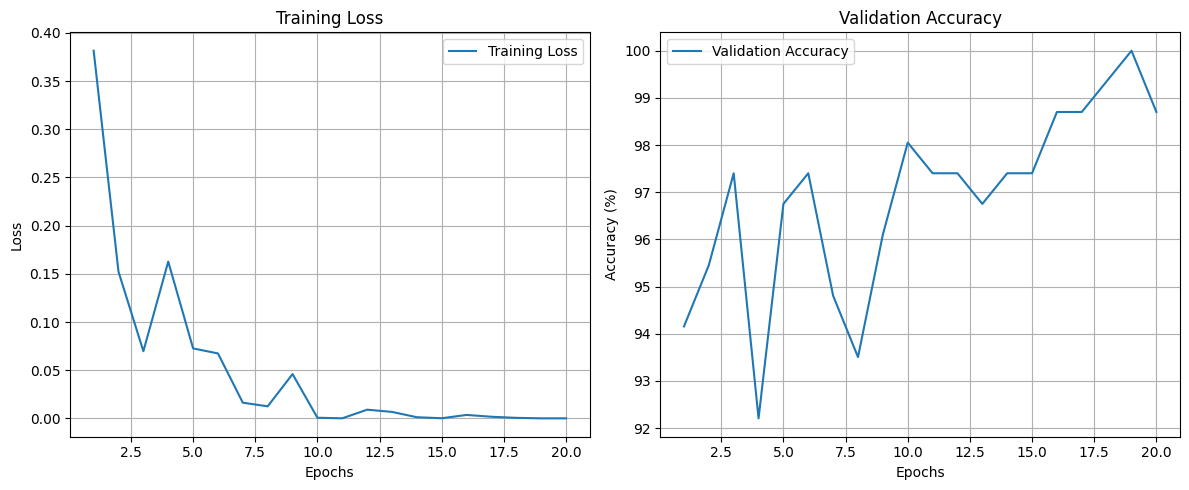

Final model saved at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/final_model_vgg_20241218.pth
Evaluating the trained model on the test set...
Test Loss: 0.103790, Test Accuracy: 93.33%
Trained model saved at /content/drive/My Drive/FYP/VGGModel/HQ2ltst_20241218/trained_model_vgg_20241218.pth


In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm  # For progress bars

# Install Optuna with visualization support
# Uncomment if not already installed
# !pip install optuna[visualization]

import optuna
from optuna.trial import TrialState
import joblib  # For saving the Optuna study

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Define the device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive to save and load the model (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define the folder to save model checkpoints
date_str = datetime.now().strftime('%Y%m%d')
checkpoint_folder = f'/content/drive/My Drive/FYP/VGGModel/HQ2ltst_{date_str}/'
os.makedirs(checkpoint_folder, exist_ok=True)

# Data Augmentation for Training Set
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG expects 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Simple resizing for validation and test sets
transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQ2/test'
train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size],
                                       generator=torch.Generator().manual_seed(42))  # Ensure reproducibility

# Create data loaders
batch_size = 16  # Reduced from 32 to 16
num_workers = 2  # Adjusted based on system recommendation

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Define class names as per dataset
class_names = train_dataset.classes  # Automatically get class names from ImageFolder
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Use Pre-trained VGG-16 model and modify it for binary classification
class VGG16Modified(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(VGG16Modified, self).__init__()
        self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        # Replace the classifier with a custom binary classification layer
        num_ftrs = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Define the validation loop returning accuracy and loss
def validate(model, loader, criterion):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    average_loss = val_loss / len(loader)
    print(f'Validation Loss: {average_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
    return accuracy, average_loss

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters using updated Optuna methods
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])

    # Suggest dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)

    # Suggest momentum only if optimizer is SGD
    if optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.5, 0.99)
    else:
        momentum = 0.0  # Not used for Adam or AdamW

    # Initialize the model with the suggested dropout rate
    model = VGG16Modified(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

    # **Reduced number of epochs**
    epochs = 5  # Changed from 20 to 5

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"Starting Trial {trial.number}, Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        average_train_loss = running_loss / len(train_loader)
        print(f"Trial {trial.number}, Epoch {epoch+1}/{epochs}, Average Train Loss: {average_train_loss:.4f}")

        # Validate the model
        val_acc, val_loss = validate(model, val_loader, criterion)
        print(f"  Validation Accuracy: {val_acc:.2f}%, Validation Loss: {val_loss:.4f}")

        # Update the scheduler
        scheduler.step(val_acc)

        # Report intermediate objective value
        trial.report(val_acc, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            print("  Trial is pruned")
            raise optuna.exceptions.TrialPruned()

        # Save the best validation accuracy for this trial
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            print(f"  New best validation accuracy: {best_val_acc:.2f}%")

    return best_val_acc

# Create the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10, timeout=None)  # Reduced from 20 to 10 trials for quicker testing

# Print study statistics
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Validation Accuracy: {trial.value:.2f}%")
print("  Best hyperparameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Save the Optuna study
study_dir = os.path.join(checkpoint_folder, 'optuna_study')
os.makedirs(study_dir, exist_ok=True)
joblib.dump(study, os.path.join(study_dir, 'study.pkl'))
print(f"Optuna study saved at {study_dir}")

# Function to plot the optimization history
def plot_optimization_history(study):
    try:
        import optuna.visualization as vis
        fig = vis.plot_optimization_history(study)
        fig.show()
    except ImportError:
        print("Optuna visualization module is not installed. Please install it to view plots.")

# Function to plot the parameter importances
def plot_param_importances(study):
    try:
        import optuna.visualization as vis
        fig = vis.plot_param_importances(study)
        fig.show()
    except ImportError:
        print("Optuna visualization module is not installed. Please install it to view plots.")

# Plot optimization history
plot_optimization_history(study)

# Plot parameter importances
plot_param_importances(study)

# Retrain the model with the best hyperparameters
def train_with_best_params(best_params):
    learning_rate = best_params['learning_rate']
    weight_decay = best_params['weight_decay']
    optimizer_name = best_params['optimizer']
    dropout_rate = best_params.get('dropout_rate', 0.5)

    # Retrieve momentum if optimizer is SGD
    if optimizer_name == 'SGD':
        momentum = best_params.get('momentum', 0.9)
    else:
        momentum = 0.0  # Default value for optimizers that do not use momentum

    # Initialize the model with the best dropout rate
    model = VGG16Modified(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:  # SGD
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Define scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    # **Reduced number of epochs for retraining as well**
    epochs = 20  # You can choose to keep this higher since it's the final training

    best_val_acc = 0.0
    best_model_path = os.path.join(checkpoint_folder, f"best_model_vgg_{date_str}.pth")

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Starting Epoch {epoch+1}/{epochs}")
        model.train()
        running_loss = 0.0

        for batch_idx, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Average Train Loss: {average_train_loss:.6f}")

        # Validate the model
        val_acc, val_loss = validate(model, val_loader, criterion)
        val_accuracies.append(val_acc)

        # Update the scheduler
        scheduler.step(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"  New best model saved with accuracy: {best_val_acc:.2f}% at {best_model_path}")

    # Plot training and validation metrics
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the final model
    final_model_path = os.path.join(checkpoint_folder, f"final_model_vgg_{date_str}.pth")
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved at {final_model_path}")

    return model

# Retrieve the best hyperparameters
best_params = study.best_trial.params
print("Retraining the model with the best hyperparameters...")
trained_model = train_with_best_params(best_params)

# Function to evaluate the model on the test set
def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(loader)
    accuracy = 100 * correct / total
    print(f'Test Loss: {average_test_loss:.6f}, Test Accuracy: {accuracy:.2f}%')
    return average_test_loss, accuracy

# Evaluate the trained model on the test set
print("Evaluating the trained model on the test set...")
test_loss, test_accuracy = test(trained_model, test_loader, nn.CrossEntropyLoss())

# Save the trained model
final_model_path = os.path.join(checkpoint_folder, f"trained_model_vgg_{date_str}.pth")
torch.save(trained_model.state_dict(), final_model_path)
print(f"Trained model saved at {final_model_path}")
